In [1]:
# -*- coding: utf-8 -*-
"""
@author: ofersh@telhai.ac.il
(1+1)-Evolution Strategy with the 1/5th success-rule initialized within [lb,ub]**n
The objective function evaluation calls are adjusted to the ObjectiveFunctoin interface.
"""
import MixedVariableObjectiveFunctions as f_mixed
from MixedVariableObjectiveFunctions import setC
import ellipsoidFunctions as Efunc
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def OnePlusOneEvolutionStrategy(n, lb, ub, maxEvals=1e6, func=lambda x: x.dot(x), fstop=0, seed=None,
                                    record_interval=50, beta=0.1):
    """
    (1+1)-Evolution Strategy with coordinate-wise exponential step-size adaptation.
    Each coordinate has its own sigma, which is updated as:
       sigma[i] = sigma[i] * exp(beta*(r_i - target_success_rate))
    where r_i is the success rate for coordinate i, computed over a fixed epoch.
    """
    local_state = np.random.RandomState(seed)
    fhistory, shistory = [], []
    # Initialize solution uniformly.
    xmin = local_state.uniform(size=n) * (ub - lb) + lb
    candidate = xmin.reshape(1, -1)
    fmin = func(candidate)
    fmin = fmin.item() if hasattr(fmin, "item") else fmin
    fhistory.append(fmin)

    # Initialize coordinate-wise sigma.
    sigma = np.full(n, (ub - lb) / 6.0)
    shistory.append(sigma.copy())

    # Success counter per coordinate.
    osuccess = np.zeros(n)
    evalcount = 0
    epoch = 50
    target_success_rate = 0.2  # Classic 1/5 success rate.

    while evalcount < maxEvals and fmin > fstop:
        # Generate mutation vector.
        z = local_state.normal(size=n)
        x_new = xmin + sigma * z
        x_new = np.clip(x_new, lb, ub)
        candidate = x_new.reshape(1, -1)
        f_x = func(candidate)
        f_x = f_x.item() if hasattr(f_x, "item") else f_x
        evalcount += 1

        # If the new candidate improves fitness, update.
        if f_x < fmin:
            xmin = x_new.copy()
            # Record successes per coordinate (if a coordinate was mutated, count it as success).
            osuccess += (z != 0).astype(float)
            fmin = f_x

        # Every 'epoch' iterations, update sigma exponentially.
        if evalcount % epoch == 0:
            r = osuccess / epoch  # per-coordinate success rate.
            sigma = sigma * np.exp(beta * (r - target_success_rate))
            osuccess = np.zeros(n)  # Reset success counters.
            if evalcount % record_interval == 0:
                fhistory.append(fmin)
                shistory.append(sigma.copy())

        if evalcount % record_interval == 0:
            fhistory.append(fmin)
            shistory.append(sigma.copy())

    fhistory.append(fmin)
    shistory.append(sigma.copy())

    return xmin, fmin, fhistory, shistory



In [3]:
def sample_discrete_laplace(lam):
    """
    Samples an integer from a discrete Laplace distribution with parameter lam.
    The PMF is: P(X=k) = ((1-lam)/(1+lam)) * lam**|k|  for k in Z.
    """
    A = (1 - lam) / (1 + lam)
    u = np.random.uniform()
    if u < A:
        return 0
    else:
        sign = 1 if np.random.uniform() < 0.5 else -1
        # Geometric sampling gives a magnitude >= 1.
        magnitude = np.random.geometric(p=(1 - lam))
        return sign * magnitude


def discrete_laplace_mutation(x, lb, ub, int_indices, lam=0.5):
    """
    Applies a discrete Laplace mutation to the elements of x specified by int_indices.
    Each mutated element is updated by adding a step sampled from the discrete Laplace distribution.
    """
    x_new = np.copy(x)
    for i in int_indices:
        step = sample_discrete_laplace(lam)
        x_new[i] = np.clip(x[i] + step, lb, ub)
    return x_new


def optimize_integer_part(xreal, lb, ub, n, max_evals, func, lam=0.5):
    """
    Optimizes the integer part using discrete Laplace mutations.
    If no improvement is observed for a number of iterations, a jump mutation (with an adjusted parameter)
    is performed to help escape local minima.
    """
    xint = np.round(xreal[n:]).astype(int)
    candidate = np.concatenate([xreal[:n], xint]).reshape(1, -1)
    best_fitness = func(candidate)
    best_fitness = best_fitness.item() if hasattr(best_fitness, "item") else best_fitness
    best_xint = xint.copy()

    evalcount = 0
    stuck_count = 0
    stuck_threshold = 1000  # If no improvement for 1000 iterations, consider the search stuck.
    jump_lam = lam  # Initial jump parameter for discrete Laplace.
    k_down = 0.9  # Factor to decrease jump_lam if jump is successful.
    k_up = 1.1  # Factor to increase jump_lam if jump is not successful.

    while evalcount < max_evals:
        mutated_xint = np.copy(xint)
        for i in range(len(mutated_xint)):
            if random.random() < 0.3:
                mutated_xint = discrete_laplace_mutation(mutated_xint, lb, ub, [i], lam=lam)
        candidate = np.concatenate([xreal[:n], mutated_xint]).reshape(1, -1)
        fmutated = func(candidate)
        fmutated = fmutated.item() if hasattr(fmutated, "item") else fmutated
        evalcount += 1

        if fmutated < best_fitness:
            best_fitness = fmutated
            best_xint = mutated_xint.copy()
            xint = mutated_xint.copy()
            stuck_count = 0
        else:
            stuck_count += 1

        if stuck_count >= stuck_threshold:
            # Perform a jump mutation on all integer variables using jump_lam.
            jump_mutated = discrete_laplace_mutation(xint, lb, ub, list(range(len(xint))), lam=jump_lam)
            candidate = np.concatenate([xreal[:n], jump_mutated]).reshape(1, -1)
            new_fitness = func(candidate)
            new_fitness = new_fitness.item() if hasattr(new_fitness, "item") else new_fitness
            evalcount += 1

            if new_fitness < best_fitness:
                best_fitness = new_fitness
                best_xint = jump_mutated.copy()
                xint = jump_mutated.copy()
                jump_lam = max(0.01, jump_lam * k_down)  # Decrease jump_lam for a finer jump next time.
            else:
                jump_lam = min(0.99, jump_lam * k_up)  # Increase jump_lam to try a larger jump.
            stuck_count = 0  # Reset stuck counter.

    return best_xint, best_fitness

In [4]:
def optimize_real_part(func, lb, ub, dim, record_interval=50):
    xmin, fmin, fhistory, shistory = OnePlusOneEvolutionStrategy(dim, lb, ub, func=func,
                                                                 record_interval=record_interval)
    return xmin, fmin, fhistory, shistory


def optimize_combined(func, lb, ub, dim, max_evals, record_interval=50, lam=0.3):
    real_part, fmin_real, fhistory, shistory = optimize_real_part(func, lb, ub, dim, record_interval=record_interval)
    n = dim // 2
    integer_part, fmin_integer = optimize_integer_part(real_part, lb, ub, n, max_evals, func=func, lam=lam)
    optimized_solution = np.concatenate([real_part[:n], integer_part])
    return optimized_solution, fmin_integer, fhistory

In [5]:
lb, ub = -100, 100
dim = 64
N = dim // 2
setC(N)
c = 100
lamda = 0.3

**************************genHcigar**************************
genHcigar | Run: 1:
Best Combined Fitness: 1.0062800688746247e-13 
Best solution = [ 7.00000316 -7.          7.         -7.          7.         -7.00000001
  7.         -6.99999999  7.         -7.00000001  6.99999999 -7.
  7.         -7.00000001  7.         -7.          7.         -7.00000001
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.00000001  7.         -7.          7.00000001 -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.        ]
genHcigar | Run: 2:
Best Combined Fitness: 3.9790992297342146e-13 
Best solution = [ 6.99999372 -7.00000001  7.         -7.          7.    

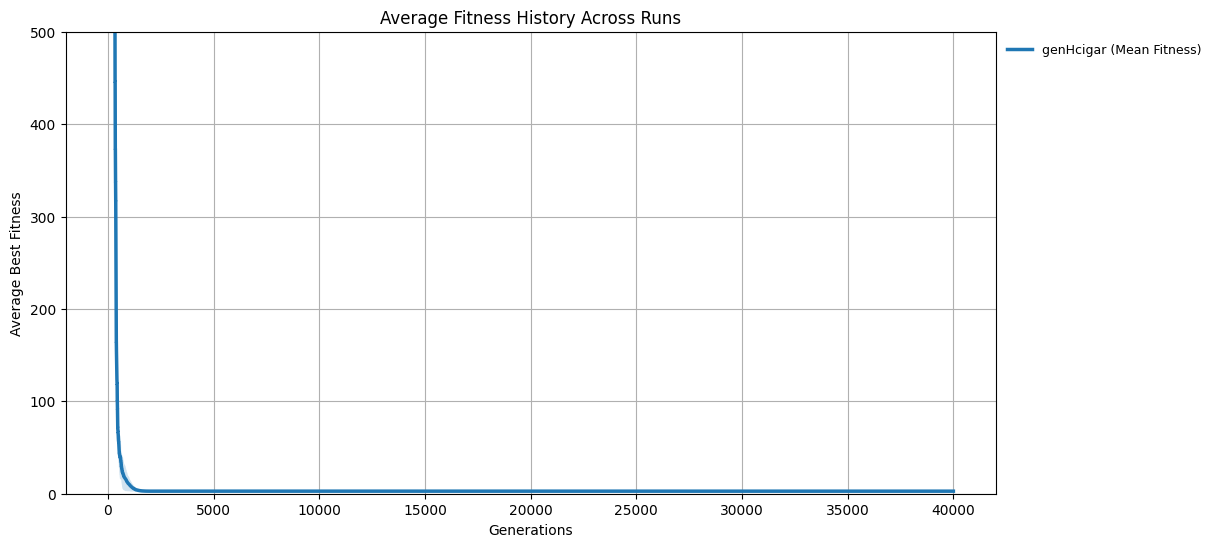

In [6]:
# genHcigar
maxEvals = 10 ** 5
NRUNS = 4
X = np.full((3 * NRUNS, dim + 2), np.nan)
plt.figure(figsize=(12, 6))
objFunc = "MixedVarsEllipsoid"

for index, funcName in enumerate(['genHcigar']):
    H = eval(f'Efunc.{funcName}')(dim, c)
    f = eval(f'f_mixed.{objFunc}')(d=dim, bid=0, ind=N, H=H, c=c, max_eval=maxEvals)

    function_histories = []  # To store fitness histories for averaging across runs.
    print(f"**************************{funcName}**************************")
    for k in range(NRUNS):
        print(f"{funcName} | Run: {k + 1}:")
        optimized_solution, fmin, fhistory = optimize_combined(func=f, lb=lb, ub=ub, dim=dim,
                                                               max_evals=maxEvals, lam=lamda)
        print(f"Best Combined Fitness: {fmin} \nBest solution = {optimized_solution}")
        function_histories.append(fhistory)
    print(f"**************************{funcName}**************************\n")

    max_length = max(len(history) for history in function_histories)
    uniform_histories = np.array([
        np.pad(history, (0, max_length - len(history)), mode='edge')
        if len(history) < max_length else history[:max_length]
        for history in function_histories
    ])
    function_histories = np.array(uniform_histories)
    function_histories = np.squeeze(function_histories)
    mean_fitness = np.mean(function_histories, axis=0)
    std_fitness = np.std(function_histories, axis=0)

    plt.plot(mean_fitness, label=f"{funcName} (Mean Fitness)", linewidth=2.5)
    if function_histories.ndim != 2:
        raise ValueError(f"function_histories has incorrect shape: {function_histories.shape}")
    plt.fill_between(range(len(mean_fitness)), mean_fitness - std_fitness, mean_fitness + std_fitness, alpha=0.2)

plt.xlabel("Generations")
plt.ylabel("Average Best Fitness")
plt.title("Average Fitness History Across Runs")
plt.grid(True)
plt.ylim(0, 500)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9, frameon=False)
plt.show()


**************************genRotatedHellipse**************************
genRotatedHellipse | Run: 1:
Best Combined Fitness: 5.190554866809136 
Best solution = [-5.06539045 -5.04973362  4.24887564 -6.45907247  5.52730412 -6.86823535
  6.03517289 -7.06307487  6.30781831 -7.17703751  6.47793036 -7.25182555
  6.594194   -7.3046758   6.67868369 -7.34400614  6.74285901 -7.37441621
  6.79326008 -7.39863166  6.83389172 -7.41837031  6.86734356 -7.43476856
  6.89536404 -7.44860821  6.91917671 -7.46044476  6.93966312 -7.47068375
  6.95747478 -7.47962817  7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.        ]
genRotatedHellipse | Run: 2:
Best Combined Fitness: 7.08627400982756 
Best solution = [-7.38676956 -8.

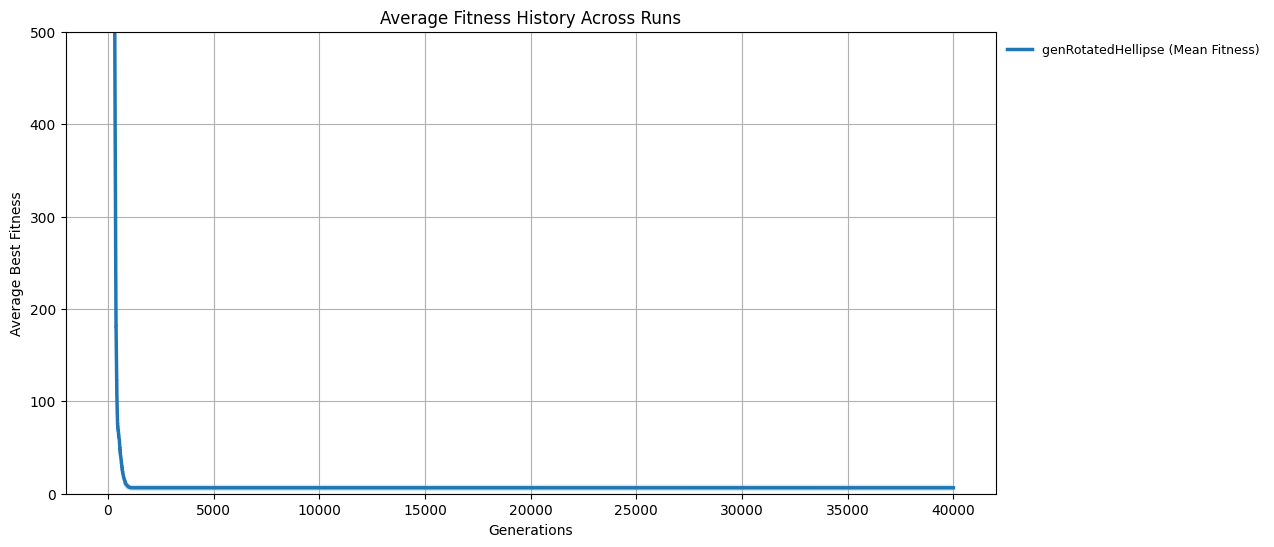

In [7]:
# genRotatedHellipse
maxEvals = 10 ** 6
NRUNS = 4
X = np.full((3 * NRUNS, dim + 2), np.nan)
plt.figure(figsize=(12, 6))
objFunc = "MixedVarsEllipsoid"

for index, funcName in enumerate(['genRotatedHellipse']):
    H = eval(f'Efunc.{funcName}')(dim, c)
    f = eval(f'f_mixed.{objFunc}')(d=dim, bid=0, ind=N, H=H, c=c, max_eval=maxEvals)

    function_histories = []  # To store fitness histories for averaging across runs.
    print(f"**************************{funcName}**************************")
    for k in range(NRUNS):
        print(f"{funcName} | Run: {k + 1}:")
        optimized_solution, fmin, fhistory = optimize_combined(func=f, lb=lb, ub=ub, dim=dim,
                                                               max_evals=maxEvals, lam=lamda)
        print(f"Best Combined Fitness: {fmin} \nBest solution = {optimized_solution}")
        function_histories.append(fhistory)
    print(f"**************************{funcName}**************************\n")

    max_length = max(len(history) for history in function_histories)
    uniform_histories = np.array([
        np.pad(history, (0, max_length - len(history)), mode='edge')
        if len(history) < max_length else history[:max_length]
        for history in function_histories
    ])
    function_histories = np.array(uniform_histories)
    function_histories = np.squeeze(function_histories)
    mean_fitness = np.mean(function_histories, axis=0)
    std_fitness = np.std(function_histories, axis=0)

    plt.plot(mean_fitness, label=f"{funcName} (Mean Fitness)", linewidth=2.5)
    if function_histories.ndim != 2:
        raise ValueError(f"function_histories has incorrect shape: {function_histories.shape}")
    plt.fill_between(range(len(mean_fitness)), mean_fitness - std_fitness, mean_fitness + std_fitness, alpha=0.2)

plt.xlabel("Generations")
plt.ylabel("Average Best Fitness")
plt.title("Average Fitness History Across Runs")
plt.grid(True)
plt.ylim(0, 500)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9, frameon=False)
plt.show()

**************************genHadamardHellipse**************************
genHadamardHellipse | Run: 1:
Best Combined Fitness: 151.81750307966945 
Best solution = [16.13392875  8.36792619 19.56252198 13.15362979 16.06973231  7.7056762
 19.77034636 11.46929669 16.59784433  8.30059378 19.54710783 12.73910583
 16.09669474  8.29335759 19.57739896 12.3900189  16.09424152  8.31686778
 19.59673868 12.76502182 16.08629914  7.709189   20.58168408 11.82223118
 16.1891633   7.88862499 19.54326806 12.67179639 16.07949855  8.26383069
 19.65307016 12.02340445 16.          8.         19.         12.
 16.          7.         19.         11.         16.          8.
 19.         12.         16.          8.         19.         11.
 16.          8.         19.         12.         16.          7.
 20.         11.         16.          8.         19.         12.
 16.          8.         19.         11.        ]
genHadamardHellipse | Run: 2:
Best Combined Fitness: 167.79280202657446 
Best solution = [-10.378067

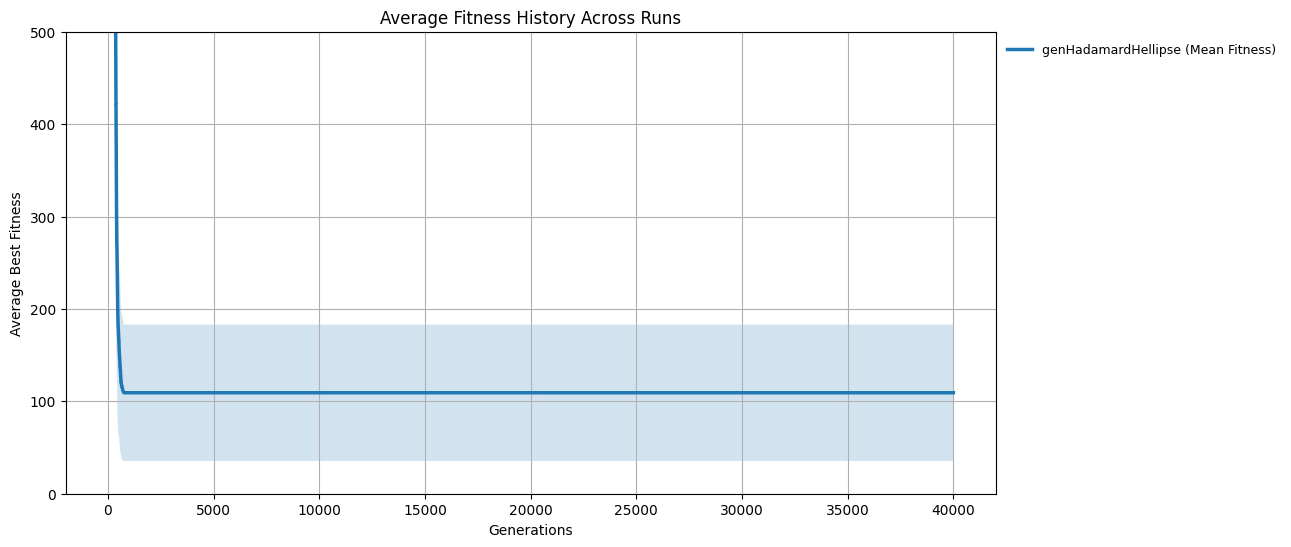

In [8]:
# genHadamardHellipse
maxEvals = 10 ** 6
NRUNS = 4
X = np.full((3 * NRUNS, dim + 2), np.nan)
plt.figure(figsize=(12, 6))
objFunc = "MixedVarsEllipsoid"

for index, funcName in enumerate(['genHadamardHellipse']):
    H = eval(f'Efunc.{funcName}')(dim, c)
    f = eval(f'f_mixed.{objFunc}')(d=dim, bid=0, ind=N, H=H, c=c, max_eval=maxEvals)

    function_histories = []  # To store fitness histories for averaging across runs.
    print(f"**************************{funcName}**************************")
    for k in range(NRUNS):
        print(f"{funcName} | Run: {k + 1}:")
        optimized_solution, fmin, fhistory = optimize_combined(func=f, lb=lb, ub=ub, dim=dim,
                                                               max_evals=maxEvals, lam=lamda)
        print(f"Best Combined Fitness: {fmin} \nBest solution = {optimized_solution}")
        function_histories.append(fhistory)
    print(f"**************************{funcName}**************************\n")

    max_length = max(len(history) for history in function_histories)
    uniform_histories = np.array([
        np.pad(history, (0, max_length - len(history)), mode='edge')
        if len(history) < max_length else history[:max_length]
        for history in function_histories
    ])
    function_histories = np.array(uniform_histories)
    function_histories = np.squeeze(function_histories)
    mean_fitness = np.mean(function_histories, axis=0)
    std_fitness = np.std(function_histories, axis=0)

    plt.plot(mean_fitness, label=f"{funcName} (Mean Fitness)", linewidth=2.5)
    if function_histories.ndim != 2:
        raise ValueError(f"function_histories has incorrect shape: {function_histories.shape}")
    plt.fill_between(range(len(mean_fitness)), mean_fitness - std_fitness, mean_fitness + std_fitness, alpha=0.2)

plt.xlabel("Generations")
plt.ylabel("Average Best Fitness")
plt.title("Average Fitness History Across Runs")
plt.grid(True)
plt.ylim(0, 500)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9, frameon=False)
plt.show()
